In [5]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
import sklearn
from sklearn.model_selection import KFold
import IPython
from IPython.display import clear_output
import copy
import matplotlib.pyplot as plt

In [2]:
# import datasets
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
building = pd.read_csv('../dataset/building_info.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')

In [3]:
building_ = building.copy()
building_ = building.drop(columns = ['건물유형'])
building_ = building_.replace('-', 0)
building_

,건물번호,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,110634.00,39570.00,0,0,0
1,2,122233.47,99000.00,0,0,0
2,3,171243.00,113950.00,40,0,0
3,4,74312.98,34419.62,60,0,0
4,5,205884.00,150000.00,0,2557,1000
...,...,...,...,...,...,...
95,96,93314.00,60500.00,0,0,0
96,97,55144.67,25880.00,0,0,0
97,98,53578.62,17373.75,0,0,0
98,99,53499.00,40636.00,0,0,0


In [4]:
display(train)
display(test)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [5]:
train_ = train.copy()
train_df = pd.merge(train_, building_)

train_df = train_df.drop(columns =  ['num_date_time', '일조(hr)', '일사(MJ/m2)'])
train_df = train_df.rename(columns = {'기온(C)':'기온', '강수량(mm)':'강수량', '풍속(m/s)':'풍속', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['시간'] = train_df['일시'].dt.hour
train_df['요일'] = train_df['일시'].dt.weekday
train_df['주말'] = train_df['요일'].isin([5,6]).astype(int)
train_df = train_df.fillna(0)
train_df = train_df.drop(columns = '일시')

In [6]:
T = 9/5*train_df['기온']
train_df['불쾌지수'] = T - 0.55*(1-train_df['습도']/100)*(T-26)+32
train_df['불쾌지수'] = pd.cut(train_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [1, 2, 3, 4])

(array([22498.,     0.,     0., 59862.,     0.,     0., 80715.,     0.,
            0., 40925.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

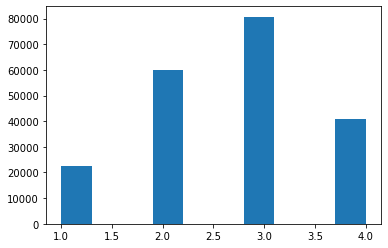

In [7]:
plt.hist(train_df['불쾌지수'])

In [8]:
train_df

,건물번호,기온,강수량,풍속,습도,전력소비량,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시간,요일,주말,불쾌지수
0,1,18.6,0.0,0.9,42.0,1085.28,110634.00,39570.00,0,0,0,0,2,0,1
1,1,18.0,0.0,1.1,45.0,1047.36,110634.00,39570.00,0,0,0,1,2,0,1
2,1,17.7,0.0,1.5,45.0,974.88,110634.00,39570.00,0,0,0,2,2,0,1
3,1,16.7,0.0,1.4,48.0,953.76,110634.00,39570.00,0,0,0,3,2,0,1
4,1,18.4,0.0,2.8,43.0,986.40,110634.00,39570.00,0,0,0,4,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,881.04,57497.84,40035.23,0,0,0,19,2,0,2
203996,100,22.4,0.0,1.3,86.0,798.96,57497.84,40035.23,0,0,0,20,2,0,2
203997,100,21.3,0.0,1.0,92.0,825.12,57497.84,40035.23,0,0,0,21,2,0,2
203998,100,21.0,0.0,0.3,94.0,640.08,57497.84,40035.23,0,0,0,22,2,0,2


In [9]:
def CDH(x):
    y = []
    for i in range(len(x)):
        if i<11:
            y.append(np.sum(x[:(i+1)]-26))
        else:
            y.append(np.sum(x[(i-11):(i+1)]-26))
    return np.array(x)

In [10]:
cdhs = np.array([])

for num in range(1, 101):
    temp = train_df[train_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

train_df['CDH'] = cdhs

In [11]:
train_df

,건물번호,기온,강수량,풍속,습도,전력소비량,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시간,요일,주말,불쾌지수,CDH
0,1,18.6,0.0,0.9,42.0,1085.28,110634.00,39570.00,0,0,0,0,2,0,1,18.6
1,1,18.0,0.0,1.1,45.0,1047.36,110634.00,39570.00,0,0,0,1,2,0,1,18.0
2,1,17.7,0.0,1.5,45.0,974.88,110634.00,39570.00,0,0,0,2,2,0,1,17.7
3,1,16.7,0.0,1.4,48.0,953.76,110634.00,39570.00,0,0,0,3,2,0,1,16.7
4,1,18.4,0.0,2.8,43.0,986.40,110634.00,39570.00,0,0,0,4,2,0,1,18.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,881.04,57497.84,40035.23,0,0,0,19,2,0,2,23.1
203996,100,22.4,0.0,1.3,86.0,798.96,57497.84,40035.23,0,0,0,20,2,0,2,22.4
203997,100,21.3,0.0,1.0,92.0,825.12,57497.84,40035.23,0,0,0,21,2,0,2,21.3
203998,100,21.0,0.0,0.3,94.0,640.08,57497.84,40035.23,0,0,0,22,2,0,2,21.0


In [19]:
test

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [24]:
test

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [25]:
test_ = test.copy()
test_df = pd.merge(test_, building_)

test_df = test_df.drop(columns =  ['num_date_time'])
test_df = test_df.rename(columns = {'기온(C)':'기온', '강수량(mm)':'강수량', '풍속(m/s)':'풍속', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})
test_df['일시'] = pd.to_datetime(test_df['일시'])
test_df['시간'] = test_df['일시'].dt.hour
test_df['요일'] = test_df['일시'].dt.weekday
test_df['주말'] = test_df['요일'].isin([5,6]).astype(int)
test_df = test_df.fillna(0)
test_df = test_df.drop(columns = '일시')

T = 9/5*test_df['기온']
test_df['불쾌지수'] = T - 0.55*(1-test_df['습도']/100)*(T-26)+32
test_df['불쾌지수'] = pd.cut(test_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [1, 2, 3, 4])

cdhs = np.array([])
for num in range(1, 101):
    temp = test_df[test_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

test_df['CDH'] = cdhs

test_df = test_df[['건물번호', '기온', '강수량', '풍속', '습도', '시간', '요일', '주말', '불쾌지수', 'CDH']]
test_dfs  = []
for i in range(1,101):
    test_dfs.append(test_df[test_df['건물번호']==i])

test_df 


,건물번호,기온,강수량,풍속,습도,시간,요일,주말,불쾌지수,CDH
0,1,23.5,0.0,2.2,72,0,3,0,2,23.5
1,1,23.0,0.0,0.9,72,1,3,0,2,23.0
2,1,22.7,0.0,1.5,75,2,3,0,2,22.7
3,1,22.1,0.0,1.3,78,3,3,0,2,22.1
4,1,21.8,0.0,1.0,77,4,3,0,2,21.8
...,...,...,...,...,...,...,...,...,...,...
16795,100,22.5,0.0,0.9,84,19,2,0,2,22.5
16796,100,20.7,0.0,0.4,95,20,2,0,2,20.7
16797,100,20.2,0.0,0.4,98,21,2,0,2,20.2
16798,100,20.1,0.0,1.1,97,22,2,0,2,20.1


In [26]:
train_df.columns

Index(['전력소비량', '건물번호', '기온', '강수량', '풍속', '습도', '시간', '요일', '주말', '불쾌지수',
       'CDH'],
      dtype='object')

In [27]:
train_df = train_df[['전력소비량', '건물번호', '기온', '강수량', '풍속', '습도', '시간', '요일', '주말', '불쾌지수', 'CDH']]
train_dfs  = []
for i in range(1,101):
    train_dfs.append(train_df[train_df['건물번호']==i]) 

In [28]:
train_input = [] 
train_target = []

for i in range(len(train_dfs)):
    train_input.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[1:]])) 
    train_target.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[0]]))

In [29]:
train_dfs[98]

,전력소비량,건물번호,기온,강수량,풍속,습도,시간,요일,주말,불쾌지수,CDH
199920,642.96,99,23.1,0.0,1.4,17.0,0,2,0,1,23.1
199921,603.36,99,23.1,0.0,3.0,17.0,1,2,0,1,23.1
199922,581.22,99,23.1,0.0,1.6,17.0,2,2,0,1,23.1
199923,599.94,99,23.0,0.0,2.6,18.0,3,2,0,1,23.0
199924,595.62,99,21.2,0.0,1.2,23.0,4,2,0,1,21.2
...,...,...,...,...,...,...,...,...,...,...,...
201955,1299.24,99,21.9,0.0,0.1,80.0,19,2,0,2,21.9
201956,1276.92,99,20.6,0.0,1.0,85.0,20,2,0,2,20.6
201957,1062.00,99,20.1,0.0,0.8,86.0,21,2,0,1,20.1
201958,865.62,99,19.4,0.0,0.7,88.0,22,2,0,1,19.4


In [31]:
random_seed = 42
features = [[], '강수량', '풍속']
K = [i for i in [5, 10]]

cat_mae_params = {
    'objective': 'MAE',
    'n_estimators': 10000,
    'early_stopping_rounds': 4, 
} # catboost hyper parameter

lgbm_mae_params = {
    'objective': 'MAE',
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'early_stopping_round': 15, 
    'num_leaves':39,
} # lightgbm hyper parameter

for feature in features: # 특정 feature dc를 drop 시킴
    for k in K: # kfold 의 nspilt 의 값 k
        folds = []
        for i in range(len(train_dfs)):
            cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
            fold = []
            for train_idx, valid_idx in cross.split(train_input[i], train_target[i]):
                fold.append((train_idx, valid_idx))
            folds.append(fold)
            
        for i in range(len(train_dfs)):
            for fold in range(k):
                print(feature, random_seed, k, i)
                train_idx, valid_idx = folds[i][fold]
                X_train = np.array(train_input[i].drop(columns = feature).iloc[train_idx])
                y_train = np.array(train_target[i].iloc[train_idx])
                X_valid = np.array(train_input[i].drop(columns = feature).iloc[valid_idx])
                y_valid = np.array(train_target[i].iloc[valid_idx])
                
                # catboost 학습 
                model = CatBoostRegressor(**cat_mae_params)
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
                v = model.predict(np.array(test_dfs[i][train_input[i].drop(columns = feature).columns])) * 0.3
                
                #lgbm 학습 
                model=LGBMRegressor(**lgbm_mae_params)
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])        
                v += model.predict(np.array(test_dfs[i][train_input[i].drop(columns = feature).columns])) * 0.7
                
                submission['answer'].iloc[(i)*168:(i+1)*168] += v/(len(K)*k*len(features))
                clear_output(True) 
                
        random_seed += 1

submission.to_csv('../submission/answer2.csv', index = False) # 파일 저장

풍속 47 10 99
0:	learn: 266.2679294	test: 247.1869197	best: 247.1869197 (0)	total: 1.88ms	remaining: 18.8s
1:	learn: 258.3803972	test: 239.7072749	best: 239.7072749 (1)	total: 3.6ms	remaining: 18s
2:	learn: 250.9830137	test: 232.8448478	best: 232.8448478 (2)	total: 6.41ms	remaining: 21.4s
3:	learn: 243.7438934	test: 225.9662975	best: 225.9662975 (3)	total: 9.12ms	remaining: 22.8s
4:	learn: 236.8070228	test: 219.5051250	best: 219.5051250 (4)	total: 11.1ms	remaining: 22.3s
5:	learn: 230.2417799	test: 213.0549808	best: 213.0549808 (5)	total: 13.8ms	remaining: 22.9s
6:	learn: 223.8736287	test: 206.8592700	best: 206.8592700 (6)	total: 16.1ms	remaining: 23s
7:	learn: 217.7074759	test: 201.0196363	best: 201.0196363 (7)	total: 18.3ms	remaining: 22.8s
8:	learn: 211.6118719	test: 195.1988159	best: 195.1988159 (8)	total: 20.3ms	remaining: 22.6s
9:	learn: 205.9319915	test: 189.8970387	best: 189.8970387 (9)	total: 22.7ms	remaining: 22.7s
10:	learn: 200.2550628	test: 184.6331103	best: 184.6331103 (10)

In [33]:
submission

,num_date_time,answer
0,1_20220825 00,2293.185968
1,1_20220825 01,2138.499923
2,1_20220825 02,2093.296109
3,1_20220825 03,1664.951365
4,1_20220825 04,1628.573873
...,...,...
16795,100_20220831 19,948.185613
16796,100_20220831 20,867.800619
16797,100_20220831 21,756.862418
16798,100_20220831 22,662.145242
